# Code for training the model

In [100]:
#importing some stuff, not sure what we will need yet

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import random

from tensorflow import keras
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report


In [101]:
#Loading Training CSV data
train=pd.read_csv("sign_mnist_train.csv")
print(train.shape)
train.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [102]:
#Loading Testing CSV data
test=pd.read_csv("sign_mnist_test.csv")
print(train.shape)
test.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [103]:
#Next we must seperate the labels from the data
label_train=train["label"]
label_test=test["label"]

img_train=train.drop(['label'],axis=1)
img_test=test.drop(['label'],axis=1)

[[0.3372549  0.19607843 0.34509804 0.42745098 0.46666667 0.50196078
  0.54509804 0.56862745 0.58823529 0.60392157 0.62352941 0.63137255
  0.63921569 0.64313725 0.65490196 0.66666667 0.6627451  0.68235294
  0.69411765 0.69411765 0.70980392 0.70980392 0.71372549 0.71764706
  0.71764706 0.7254902  0.7254902  0.72941176]
 [0.30588235 0.20784314 0.36470588 0.43529412 0.4745098  0.51764706
  0.55686275 0.57647059 0.59607843 0.61960784 0.62745098 0.63529412
  0.64313725 0.65490196 0.65882353 0.67843137 0.69019608 0.55294118
  0.69019608 0.70980392 0.70980392 0.71764706 0.71764706 0.71764706
  0.7254902  0.73333333 0.73333333 0.73333333]
 [0.27843137 0.22352941 0.37647059 0.44313725 0.48235294 0.5254902
  0.56078431 0.58039216 0.6        0.61960784 0.63137255 0.63529412
  0.64705882 0.6627451  0.6627451  0.68627451 0.75294118 0.49019608
  0.62352941 0.7254902  0.70980392 0.71764706 0.72156863 0.7254902
  0.73333333 0.73333333 0.73333333 0.73333333]
 [0.23137255 0.24313725 0.38431373 0.44705882

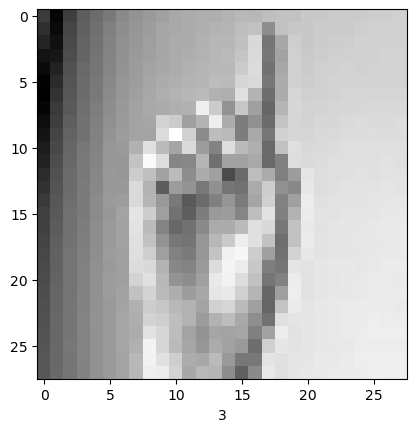

In [104]:
#visualizing what a random image looks like in the dataset to ensure accuracy
sampImg = random.randint(0,len(img_train.index))
fig, ax = plt.subplots()
i=img_train.iloc[sampImg].to_numpy()
i=i.reshape((28,28))
print(i/255)
ax.imshow(i, cmap = 'gray')
ax.set_xlabel(label_train.iloc[sampImg])
plt.show()

#A=0
#B=1
#C=2
#etc

In [105]:
#reshaping the image data into a MNIST type format
train_images = img_train.values.reshape(-1,28,28,1)
test_images = img_test.values.reshape(-1,28,28,1)

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

In [106]:
# fixing label data
labels = to_categorical(label_train, num_classes = 25)
labels_test = to_categorical(label_test, num_classes = 25)


In [107]:
#splitting training data to such that we can use the validation dataset for post model metrics lice confusion matrix
X_train, X_val, Y_train, Y_val = train_test_split(train_images, labels, test_size=0.10, random_state=69)

print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (24709, 28, 28, 1)
x_test shape (2746, 28, 28, 1)
y_train shape (24709, 25)
y_test shape (2746, 25)


In [112]:
#creating more data using image data generator (this will be used late, just setting it up)
datagen = ImageDataGenerator(
    rotation_range = 5,
    zoom_range =0,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_data = datagen.flow(X_train, Y_train, batch_size = 12800)
test_data = datagen.flow(X_val, Y_val, batch_size = 12800)

In [109]:
# Define the model architecture.
model = tf.keras.models.Sequential([
    layers.Conv2D(100, (5, 5), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
    layers.Conv2D(50, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
    layers.Conv2D(10, (3, 3), activation = 'relu', padding = 'same', input_shape = (14, 14, 1)),

    
    layers.Flatten(),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(25, activation = 'softmax')
])

# summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 100)       2600      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 50)        45050     
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 10)        4510      
                                                                 
 flatten_2 (Flatten)         (None, 7840)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               784100    
                                                                 
 dense_7 (Dense)             (None, 25)                2525      
                                                                 
Total params: 838785 (3.20 MB)
Trainable params: 83878

In [110]:
# compilinga and training the model
model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])



In [115]:
# training model
trained_model = model.fit(X_train,Y_train, epochs=1, validation_data=test_data)

773/773 [==============================] - 64s 83ms/step - loss: 0.0252 - accuracy: 0.9941 - val_loss: 3.0693 - val_accuracy: 0.7385


In [14]:
# defining some functions to be used later

#model size function
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

#clustering function
def cluster_model(model, num_clust, train_images, train_labels, epochs): 
    # ---------- Defining clustering params ----------
    cluster_weights = tfmot.clustering.keras.cluster_weights

    clustering_params = {
    'number_of_clusters': num_clust,
    'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS,
    'preserve_sparsity': True
    }

    # -------  Clustering --------------
    clustered_model = cluster_weights(model, **clustering_params)

    clustered_model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

    clustered_model.fit(train_images, train_labels, epochs = epochs, validation_split =0.1)

    stripped_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)

    # ------- Printing Summary ----------
    clustered_model.summary()

    return clustered_model, stripped_clustered_model

def quantize_model(model, quant):

    #-------------Quantizing------------------
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    if quant == 16: #using float 16 if requested
        converter.target_spec.supported_types = [tf.float16]
        quantized_tflite_model = converter.convert()


    else: #using 8bit
        quantized_tflite_model = converter.convert()
        
    # with open(f'quantized_model.tflite', 'wb') as f:
    #     f.write(quantized_tflite_model)
    # interpreter_quant = tf.lite.Interpreter(model_path=str(f'quantized_model.tflite'))
    # interpreter_quant.allocate_tensors()     



    return quantized_tflite_model

def iterative_prune_model(model, initial_sparsity, final_sparsity, begin_step, end_step, train_images, train_labels, epochs):
  # --------- Pruning Variable Setup ---------
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  # ------------- Pruning Model -------------
  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  pruned_model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(train_images, train_labels, epochs=epochs, validation_split=0.1,
                    callbacks=callbacks)

  # -------- Strip Pruning -------------
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  # ------- Printing Summaries ----------
  pruned_model.summary()
  stripped_pruned_model.summary()

  return pruned_model, stripped_pruned_model



In [116]:
#saving model
model.save('trained_signLang_model.h5')

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
#getting baseline numbers to understand model.
model = tf.keras.models.load_model('trained_signLang_model.h5')

# Evaluate prediction accuracy
test_loss, test_acc = model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size('trained_signLang_model.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

225/225 - 3s - loss: 0.0557 - accuracy: 0.9805 - 3s/epoch - 13ms/step
225/225 [==============================] - 3s 13ms/step
Model Size: 2600322.00 bytes
Model Accuracy: 98.04796576499939 %
Inference Time is 0.000445003258204633 s


In [31]:
# first thing we will do to reduce model size is prune it

# load model
loaded_model = tf.keras.models.load_model('trained_signLang_model.h5')

#variables that are to be manipulated
initial_sparsity = 0
final_sparsity = 0.9
begin_step = 0
end_step = 300
epochs = 2

#function call
pruned_model, stripped_pruned_model = iterative_prune_model(loaded_model, initial_sparsity, final_sparsity, 
                                                            begin_step, end_step, train_images, 
                                                            labels, epochs)


Epoch 1/2
773/773 [==============================] - 52s 65ms/step - loss: 0.2854 - accuracy: 0.9336 - val_loss: 0.0406 - val_accuracy: 0.9927
Epoch 2/2
773/773 [==============================] - 50s 65ms/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 0.0016 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 100)       5102      
 _3 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        90052     
 _4 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                            

In [32]:
#saving model
stripped_pruned_model.save(f'stripPruned_signLang_model_{final_sparsity}.h5')

In [33]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

conv2d_3/kernel:0: 90.00% sparsity  (2250/2500)
conv2d_4/kernel:0: 90.00% sparsity  (40500/45000)
conv2d_5/kernel:0: 90.00% sparsity  (4050/4500)
dense_3/kernel:0: 90.00% sparsity  (220500/245000)
dense_4/kernel:0: 90.00% sparsity  (45000/50000)
dense_5/kernel:0: 90.00% sparsity  (2250/2500)


In [34]:
#getting baseline numbers to understand model.
s_model = pruned_model
# Evaluate prediction accuracy
test_loss, test_acc = s_model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = s_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size(f'stripPruned_signLang_model_{final_sparsity}.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

225/225 - 3s - loss: 0.2387 - accuracy: 0.9445 - 3s/epoch - 14ms/step
225/225 [==============================] - 3s 14ms/step
Model Size: 275290.00 bytes
Model Accuracy: 94.45064067840576 %
Inference Time is 0.00048677002459481916 s


In [36]:
#clustering the pruned model and perserving its sparcity

model = tf.keras.models.load_model(f'stripPruned_signLang_model_{final_sparsity}.h5')

#defining some variables
num_clust = 16

#Function call
clustered_model, strip_clust_model = cluster_model(model, num_clust, train_images, labels, epochs)

strip_clust_model.save(f'stripClust_signLang_model_{final_sparsity}_{num_clust}.h5')


Epoch 1/2
773/773 [==============================] - 61s 77ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 1.1800e-04 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 58s 75ms/step - loss: 6.4901e-04 - accuracy: 0.9998 - val_loss: 3.9272e-05 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5116      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90066     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                    

In [ ]:
#getting baseline numbers to understand model.
c_model = clustered_model
# Evaluate prediction accuracy
test_loss, test_acc = c_model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = c_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size(f'stripClust_signLang_model_{final_sparsity}_{num_clust}.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

225/225 - 4s - loss: 0.2296 - accuracy: 0.9346 - 4s/epoch - 19ms/step
225/225 [==============================] - 5s 20ms/step
Model Size: 70124.00 bytes
Model Accuracy: 93.46067905426025 %
Inference Time is 0.000670921383659333 s


# Evaluating different combinations

In these graphs we will look at how different pruning and clustering levels affect inference time, size and accuracy to help us determine the final model

In [39]:
from pandas import DataFrame as df

prunes = [0.1,0.5,0.75,0.9,0.95]
clusters = [4,8,16,32]
metrics = df(columns=['%Prune','Clusters','Accuracy','Size',"Time"])

for i in prunes:
    for j in clusters:
        # ------------- Prunining --------------------
        # load model
        loaded_model = tf.keras.models.load_model('trained_signLang_model.h5')

        #variables that are to be manipulated
        initial_sparsity = 0
        final_sparsity = i
        begin_step = 0
        end_step = 300
        epochs = 2

        #function call
        pruned_model, stripped_pruned_model = iterative_prune_model(loaded_model, initial_sparsity, final_sparsity, 
                                                                    begin_step, end_step, train_images, 
                                                                    labels, epochs)
        
        #saving model
        stripped_pruned_model.save(f'stripPruned_signLang_model_{final_sparsity}.h5')
        
        # ------------- Clustering --------------------
        
        #clustering the pruned model and perserving its sparcity

        model = tf.keras.models.load_model(f'stripPruned_signLang_model_{final_sparsity}.h5')

        #defining some variables
        num_clust = j

        #Function call
        clustered_model, strip_clust_model = cluster_model(model, num_clust, train_images, labels, epochs)

        strip_clust_model.save(f'stripClust_signLang_model_{final_sparsity}_{num_clust}.h5')

        # ----------------- Evaluating -----------------
        c_model = clustered_model

        # Evaluate prediction accuracy
        test_loss, test_acc = c_model.evaluate(test_images, labels_test, verbose=2)

        # Evaluate Inference Time
        startTime = time.time()
        prediction = c_model.predict(test_images)
        executionTime = (time.time() - startTime)/len(test_images)

        
        metrics.loc[len(metrics)]=[str(i),str(j),test_acc*100,
                                   get_gzipped_model_size(f'stripClust_signLang_model_{final_sparsity}_{num_clust}.h5'),
                                   executionTime]

Epoch 1/2
773/773 [==============================] - 59s 74ms/step - loss: 0.0119 - accuracy: 0.9969 - val_loss: 2.7385e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 57s 74ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 8.1885e-07 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 100)       5102      
 _3 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        90052     
 _4 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                    

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 62s 78ms/step - loss: 0.0279 - accuracy: 0.9934 - val_loss: 2.9094e-04 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 61s 79ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0059 - val_accuracy: 0.9982
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5104      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90054     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                            

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 65s 82ms/step - loss: 0.0119 - accuracy: 0.9968 - val_loss: 8.8227e-04 - val_accuracy: 0.9996
Epoch 2/2
773/773 [==============================] - 60s 78ms/step - loss: 0.0069 - accuracy: 0.9986 - val_loss: 4.9723e-05 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5108      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90058     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                        

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 65s 82ms/step - loss: 0.0082 - accuracy: 0.9979 - val_loss: 6.7017e-04 - val_accuracy: 0.9996
Epoch 2/2
773/773 [==============================] - 64s 82ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0118 - val_accuracy: 0.9956
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5116      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90066     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                            

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 73s 92ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9971
Epoch 2/2
773/773 [==============================] - 71s 92ms/step - loss: 2.7993e-04 - accuracy: 0.9999 - val_loss: 5.6767e-06 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5132      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90082     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                        

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 63s 80ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 5.3494e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 61s 80ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0128 - val_accuracy: 0.9953
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5104      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90054     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                            

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 64s 82ms/step - loss: 3.1418e-04 - accuracy: 0.9998 - val_loss: 5.2749e-06 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 62s 80ms/step - loss: 6.7694e-05 - accuracy: 1.0000 - val_loss: 2.2375e-04 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5108      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90058     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 68s 87ms/step - loss: 1.6899e-06 - accuracy: 1.0000 - val_loss: 6.8743e-06 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 67s 87ms/step - loss: 1.1950e-06 - accuracy: 1.0000 - val_loss: 1.8730e-06 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5116      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90066     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 75s 95ms/step - loss: 1.1526e-06 - accuracy: 1.0000 - val_loss: 6.5117e-07 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 73s 94ms/step - loss: 5.5082e-07 - accuracy: 1.0000 - val_loss: 3.7242e-07 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5132      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90082     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 61s 77ms/step - loss: 0.0155 - accuracy: 0.9971 - val_loss: 1.5439e-04 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 60s 78ms/step - loss: 7.4523e-04 - accuracy: 0.9998 - val_loss: 8.9862e-05 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5104      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90054     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                    

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 63s 79ms/step - loss: 1.4366e-04 - accuracy: 1.0000 - val_loss: 2.2307e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 62s 80ms/step - loss: 7.4822e-04 - accuracy: 0.9998 - val_loss: 0.0014 - val_accuracy: 0.9996
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5108      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90058     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                    

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 65s 82ms/step - loss: 2.7777e-04 - accuracy: 1.0000 - val_loss: 1.3644e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 64s 83ms/step - loss: 2.4310e-04 - accuracy: 0.9999 - val_loss: 2.2248e-05 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5116      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90066     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 75s 95ms/step - loss: 1.2167e-05 - accuracy: 1.0000 - val_loss: 3.3398e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 75s 98ms/step - loss: 1.8547e-04 - accuracy: 0.9999 - val_loss: 5.7114e-06 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5132      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90082     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 65s 82ms/step - loss: 0.0880 - accuracy: 0.9841 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 63s 82ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 6.2286e-04 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5104      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90054     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                            

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 68s 87ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 2.6933e-04 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 66s 85ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 8.9305e-04 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5108      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90058     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                        

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 73s 92ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 4.1193e-04 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 67s 87ms/step - loss: 1.7983e-04 - accuracy: 1.0000 - val_loss: 5.6234e-05 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5116      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90066     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                    

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 74s 94ms/step - loss: 5.8722e-04 - accuracy: 1.0000 - val_loss: 6.2898e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 73s 94ms/step - loss: 2.3136e-04 - accuracy: 0.9999 - val_loss: 3.2129e-05 - val_accuracy: 1.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5132      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90082     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 63s 80ms/step - loss: 0.2754 - accuracy: 0.9168 - val_loss: 0.2896 - val_accuracy: 0.9020
Epoch 2/2
773/773 [==============================] - 61s 79ms/step - loss: 0.1552 - accuracy: 0.9486 - val_loss: 0.1367 - val_accuracy: 0.9508
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5104      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90054     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 64s 80ms/step - loss: 0.1429 - accuracy: 0.9566 - val_loss: 0.1272 - val_accuracy: 0.9541
Epoch 2/2
773/773 [==============================] - 63s 82ms/step - loss: 0.0713 - accuracy: 0.9791 - val_loss: 0.0349 - val_accuracy: 0.9938
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5108      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90058     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 68s 86ms/step - loss: 0.1148 - accuracy: 0.9660 - val_loss: 0.2128 - val_accuracy: 0.9177
Epoch 2/2
773/773 [==============================] - 65s 84ms/step - loss: 0.0503 - accuracy: 0.9855 - val_loss: 0.0471 - val_accuracy: 0.9843
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5116      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90066     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 72s 92ms/step - loss: 0.0916 - accuracy: 0.9741 - val_loss: 0.0413 - val_accuracy: 0.9891
Epoch 2/2
773/773 [==============================] - 71s 92ms/step - loss: 0.0308 - accuracy: 0.9930 - val_loss: 0.0121 - val_accuracy: 0.9989
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_3 (ClusterW  (None, 28, 28, 100)       5132      
 eights)                                                         
                                                                 
 cluster_conv2d_4 (ClusterW  (None, 28, 28, 50)        90082     
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 14, 14, 50)        0         
 lusterWeights)                                                  
                                

In [40]:
metrics.to_csv('PruningClusteringCombos.csv', index=False)  

In [50]:
metrics.iloc[3::4,2]


3     98.396540
7     99.525934
11    97.350806
15    95.315117
19    88.761854
Name: Accuracy, dtype: float64

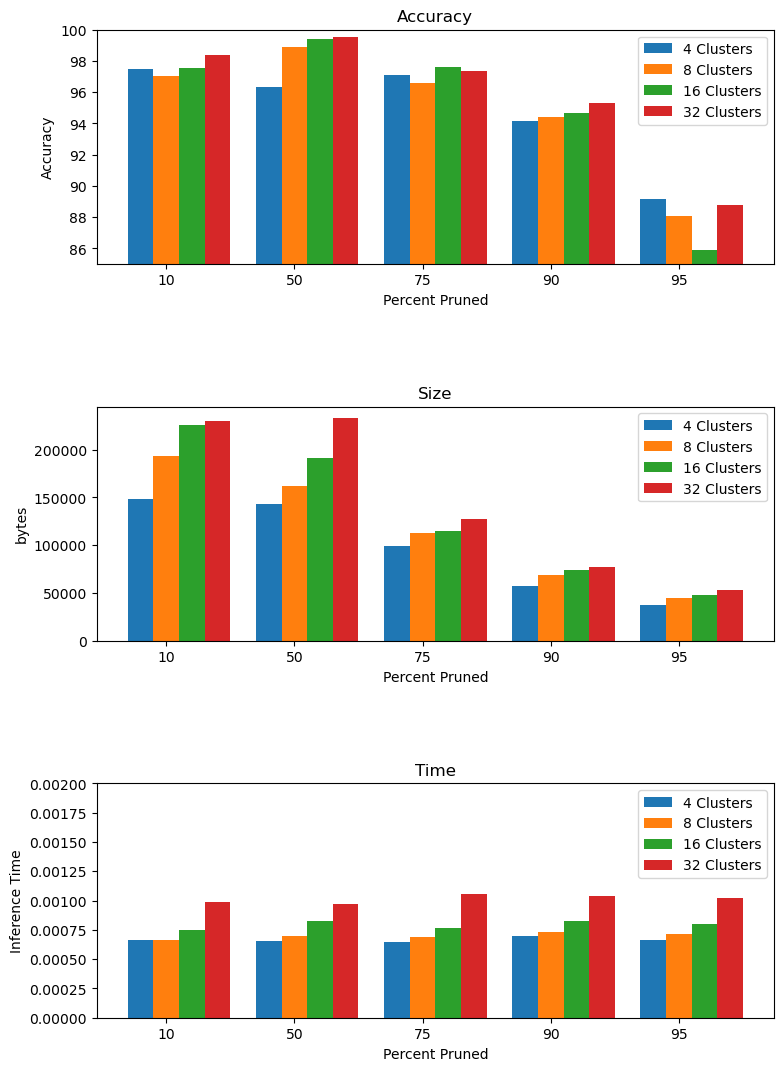

In [54]:
#graphing the data created in the cell above

#loading data
metrics = pd.read_csv("PruningClusteringCombos.csv")

#hidden x values and labels
val=[-0.2,0.8,1.8,2.8,3.8]
val2=[0.0,1.0,2.0,3.0,4.0]
val3=[0.2,1.2,2.2,3.2,4.2]
val4=[0.4,1.4,2.4,3.4,4.4]
text=['10','50','75','90','95']

#graphing
#main figure code
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.tight_layout(pad=2)
fig.set_size_inches(8, 12)

#accuracy over pruning and clustering combinations
ax1.bar(val, metrics.iloc[::4,2], label='4 Clusters', width=0.2)
ax1.bar(val2, metrics.iloc[1::4,2], label='8 Clusters', width=0.2)
ax1.bar(val3, metrics.iloc[2::4,2], label='16 Clusters', width=0.2)
ax1.bar(val4, metrics.iloc[3::4,2], label='32 Clusters', width=0.2)
ax1.set_title("Accuracy")
ax1.set_xlabel("Percent Pruned")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([85,100])
ax1.set_xticks(val2)
ax1.set_xticklabels(text)
ax1.legend()

#Size bar graphs
ax2.bar(val, metrics.iloc[::4,3], label='4 Clusters', width=0.2)
ax2.bar(val2, metrics.iloc[1::4,3], label='8 Clusters', width=0.2)
ax2.bar(val3, metrics.iloc[2::4,3], label='16 Clusters', width=0.2)
ax2.bar(val4, metrics.iloc[3::4,3], label='32 Clusters', width=0.2)
ax2.set_title("Size")
ax2.set_xlabel("Percent Pruned")
ax2.set_ylabel("bytes")
ax2.set_xticks(val2)
ax2.set_xticklabels(text)
ax2.legend()

#inference time bar graphs
ax3.bar(val, metrics.iloc[::4,4], label='4 Clusters', width=0.2)
ax3.bar(val2, metrics.iloc[1::4,4], label='8 Clusters', width=0.2)
ax3.bar(val3, metrics.iloc[2::4,4], label='16 Clusters', width=0.2)
ax3.bar(val4, metrics.iloc[3::4,4], label='32 Clusters', width=0.2)
ax3.set_title("Time")
ax3.set_xlabel("Percent Pruned")
ax3.set_ylabel("Inference Time")
ax3.set_xticks(val2)
ax3.set_xticklabels(text)
ax3.set_ylim([0,0.002])
ax3.legend()

Based upon the above graphs. We have determined that the model  with a cluster of 32 and a pruning of 75% is best. It minimizes size while still keeping a practically real time prediction and >95% accuracy.

# Final model metrics calculations

In [21]:
#loading the model
clusters = 32
final_sparsity = 0.75
model =  tf.keras.models.load_model(f'stripClust_signLang_model_{final_sparsity}_{clusters}.h5')

In [17]:
#re-compiling the model
model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [61]:
#getting loss and accuracy of model
loss, acc = model.evaluate(test_images, labels_test, verbose=2)

225/225 - 3s - loss: 0.1068 - accuracy: 0.9735 - 3s/epoch - 15ms/step


225/225 [==============================] - 5s 23ms/step


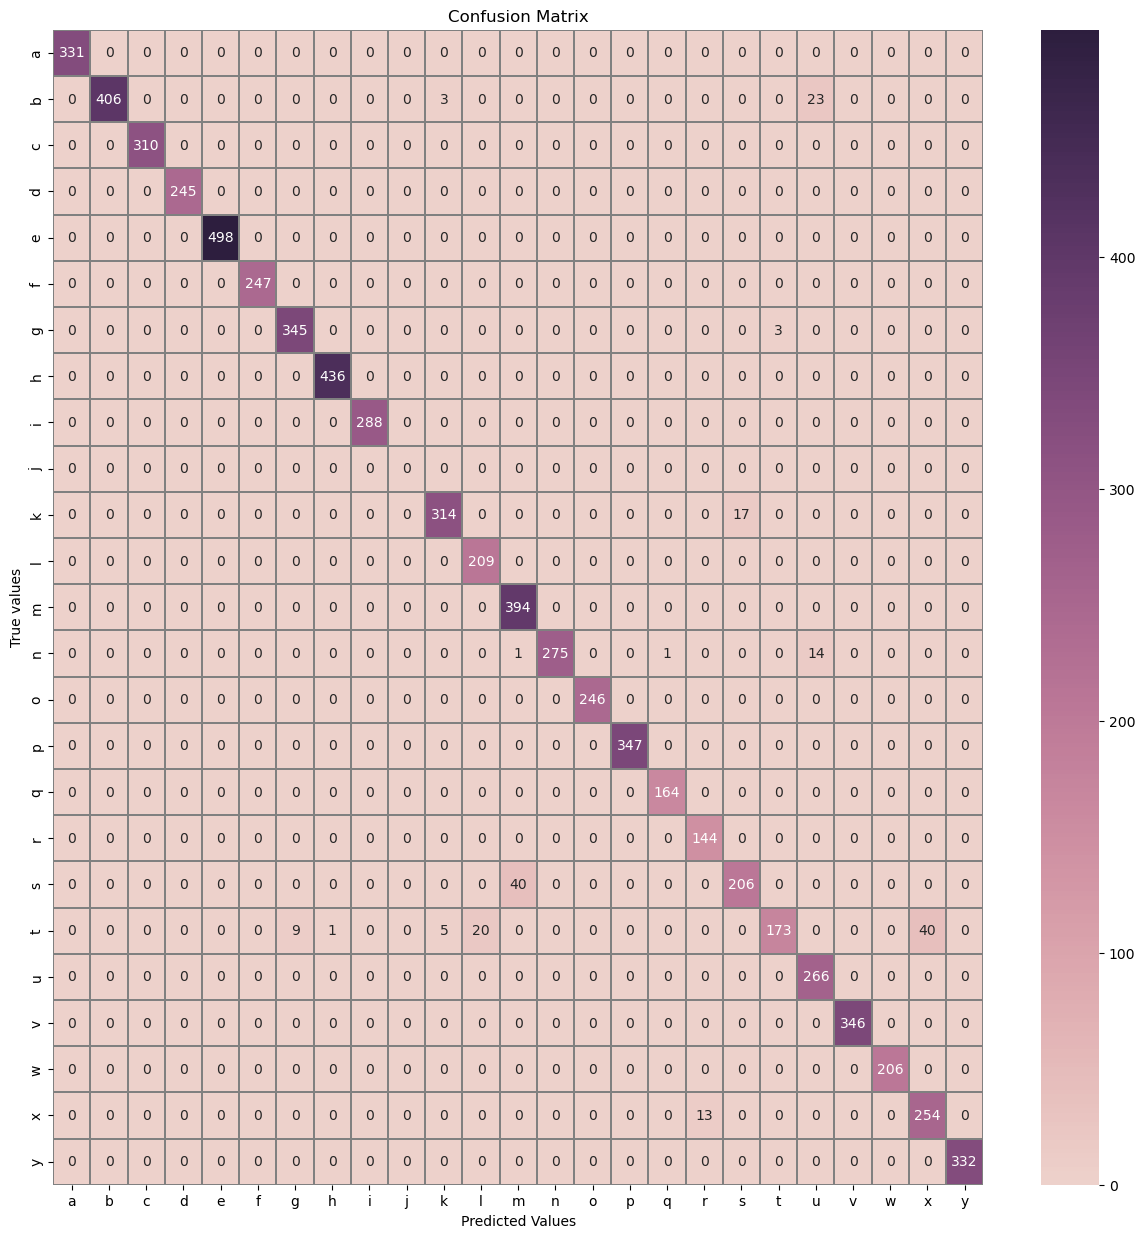

In [31]:
#creating confusion matrix
import seaborn as sns
from seaborn import heatmap

#generating data
predictions = model.predict(test_images)
data = tf.math.confusion_matrix(np.argmax(labels_test, axis=1), np.argmax(predictions, axis = 1))

#labels
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
ticks = np.arange(25)

#ploting code
fig, ax = plt.subplots(figsize=(15,15))
heatmap(data, cmap=sns.cubehelix_palette(as_cmap=True), linecolor="gray", linewidths=0.01, annot=True, ax=ax, fmt='.3g')
plt.xlabel("Predicted Values")
plt.ylabel("True values")
plt.xticks(ticks+0.5,labels=letters)
plt.yticks(ticks+0.5,labels=letters)
plt.title("Confusion Matrix")
plt.show()

In [39]:
# getting precision and recall
y_pred = model.predict(test_images)
predicted_classes = np.argmax(y_pred, axis=1)
class_labels = np.argmax(labels_test, axis=1)

#defining some varaiables to make the output nicer
letters = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
l = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

#getting precision and recall in convenient report
report = classification_report(class_labels,predicted_classes,labels=l,target_names=letters)

#printing results
print(report)

225/225 [==============================] - 4s 20ms/step
              precision    recall  f1-score   support

           a       1.00      1.00      1.00       331
           b       1.00      0.94      0.97       432
           c       1.00      1.00      1.00       310
           d       1.00      1.00      1.00       245
           e       1.00      1.00      1.00       498
           f       1.00      1.00      1.00       247
           g       0.97      0.99      0.98       348
           h       1.00      1.00      1.00       436
           i       1.00      1.00      1.00       288
           k       0.98      0.95      0.96       331
           l       0.91      1.00      0.95       209
           m       0.91      1.00      0.95       394
           n       1.00      0.95      0.97       291
           o       1.00      1.00      1.00       246
           p       1.00      1.00      1.00       347
           q       0.99      1.00      1.00       164
           r       0.92  

In [ ]:
[[0.56470588 0.57647059 0.58823529 0.59215686 0.6        0.61176471
  0.61960784 0.62352941 0.63137255 0.63921569 0.64313725 0.64313725
  0.64705882 0.64705882 0.65098039 0.65490196 0.65490196 0.65490196
  0.65490196 0.65098039 0.65098039 0.65490196 0.65882353 0.65490196
  0.65490196 0.65098039 0.64705882 0.64313725]
 [0.56862745 0.58039216 0.58823529 0.59215686 0.6        0.61176471
  0.61960784 0.62352941 0.63137255 0.63921569 0.64313725 0.64313725
  0.64705882 0.65098039 0.65098039 0.65098039 0.65882353 0.65490196
  0.65490196 0.65490196 0.65490196 0.65882353 0.65882353 0.65490196
  0.65490196 0.65490196 0.65098039 0.64705882]
 [0.57254902 0.58431373 0.59607843 0.6        0.60784314 0.61568627
  0.62352941 0.62745098 0.63921569 0.64313725 0.64705882 0.64705882
  0.65098039 0.65490196 0.65882353 0.62352941 0.59215686 0.65490196
  0.6627451  0.6627451  0.66666667 0.66666667 0.6627451  0.65882353
  0.65490196 0.65490196 0.65882353 0.65490196]
 [0.58039216 0.58823529 0.59607843 0.60784314 0.61568627 0.61960784
  0.62745098 0.63529412 0.64313725 0.64705882 0.65490196 0.65882353
  0.65490196 0.65098039 0.68235294 0.61568627 0.43137255 0.61568627
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.6627451
  0.65882353 0.65882353 0.65882353 0.65490196]
 [0.58823529 0.59215686 0.6        0.61568627 0.61960784 0.62745098
  0.63529412 0.64313725 0.64705882 0.65098039 0.65882353 0.65882353
  0.66666667 0.6627451  0.70196078 0.63137255 0.40392157 0.57254902
  0.6745098  0.67058824 0.67058824 0.67058824 0.66666667 0.66666667
  0.66666667 0.66666667 0.6627451  0.65882353]
 [0.59215686 0.59607843 0.60784314 0.61568627 0.62745098 0.63921569
  0.64313725 0.65098039 0.65098039 0.65882353 0.6627451  0.6627451
  0.67058824 0.66666667 0.71372549 0.61176471 0.40784314 0.55294118
  0.68235294 0.6745098  0.6745098  0.6745098  0.6745098  0.67058824
  0.67058824 0.66666667 0.6627451  0.65490196]
 [0.59607843 0.60784314 0.61960784 0.62352941 0.63529412 0.64705882
  0.64705882 0.65098039 0.65490196 0.6627451  0.67058824 0.6745098
  0.67843137 0.67058824 0.7372549  0.61960784 0.41960784 0.54901961
  0.68235294 0.6745098  0.67843137 0.67843137 0.67843137 0.6745098
  0.6745098  0.67058824 0.66666667 0.65882353]
 [0.6        0.61176471 0.62352941 0.63137255 0.63529412 0.64313725
  0.65098039 0.65490196 0.6627451  0.67058824 0.67058824 0.6745098
  0.67843137 0.67843137 0.74117647 0.6        0.41568627 0.56078431
  0.69019608 0.68235294 0.68235294 0.68235294 0.68627451 0.67843137
  0.67843137 0.6745098  0.6745098  0.67058824]
 [0.60784314 0.61960784 0.62745098 0.63137255 0.64705882 0.61176471
  0.61176471 0.6745098  0.63529412 0.58039216 0.6627451  0.65098039
  0.56078431 0.63921569 0.72941176 0.55294118 0.40784314 0.58431373
  0.69411765 0.69019608 0.68627451 0.68627451 0.69019608 0.68235294
  0.68235294 0.68235294 0.67843137 0.6745098 ]
 [0.61176471 0.62352941 0.62352941 0.65490196 0.7372549  0.59215686
  0.49019608 0.6627451  0.61568627 0.4627451  0.59607843 0.62352941
  0.48235294 0.50196078 0.69411765 0.54901961 0.39607843 0.61960784
  0.69803922 0.69411765 0.69411765 0.69411765 0.69019608 0.69019608
  0.69019608 0.68627451 0.68235294 0.68235294]
 [0.61176471 0.62352941 0.62745098 0.7372549  0.80392157 0.64313725
  0.49411765 0.63921569 0.58431373 0.47843137 0.62745098 0.56862745
  0.46666667 0.41960784 0.61960784 0.50980392 0.39607843 0.65490196
  0.69803922 0.69411765 0.69803922 0.69411765 0.69411765 0.69411765
  0.69019608 0.68627451 0.68627451 0.68627451]
 [0.61568627 0.62745098 0.64313725 0.74117647 0.74901961 0.63137255
  0.50980392 0.68235294 0.57647059 0.49803922 0.65490196 0.54117647
  0.41568627 0.34509804 0.44313725 0.40784314 0.40392157 0.67843137
  0.70196078 0.70196078 0.70196078 0.69803922 0.70196078 0.69803922
  0.69803922 0.69019608 0.68627451 0.68627451]
 [0.61960784 0.62352941 0.70196078 0.76078431 0.67843137 0.50588235
  0.50980392 0.69803922 0.5372549  0.52156863 0.65882353 0.49803922
  0.36078431 0.30196078 0.3254902  0.3372549  0.41176471 0.69803922
  0.70588235 0.70196078 0.70588235 0.70196078 0.70588235 0.70196078
  0.69803922 0.69803922 0.69019608 0.68627451]
 [0.61960784 0.64313725 0.75686275 0.69803922 0.62745098 0.43921569
  0.47843137 0.58431373 0.44313725 0.43921569 0.57254902 0.43529412
  0.30980392 0.27843137 0.3254902  0.3254902  0.43529412 0.70980392
  0.70588235 0.70588235 0.70588235 0.70980392 0.70980392 0.70588235
  0.70196078 0.70196078 0.69803922 0.69411765]
 [0.61960784 0.69411765 0.76470588 0.64705882 0.54117647 0.42352941
  0.37647059 0.44313725 0.31372549 0.32941176 0.43921569 0.35294118
  0.25490196 0.28235294 0.3372549  0.33333333 0.45490196 0.71372549
  0.71372549 0.70980392 0.70980392 0.70588235 0.68235294 0.65098039
  0.63137255 0.63529412 0.68235294 0.69803922]
 [0.62745098 0.77647059 0.76470588 0.65882353 0.56078431 0.43921569
  0.38039216 0.42352941 0.28627451 0.36862745 0.45490196 0.32156863
  0.24705882 0.30980392 0.36078431 0.35294118 0.48235294 0.72156863
  0.72156863 0.70980392 0.69803922 0.64705882 0.56862745 0.49411765
  0.46666667 0.44313725 0.52941176 0.69803922]
 [0.67843137 0.83921569 0.75686275 0.6627451  0.59607843 0.55294118
  0.55686275 0.56470588 0.5372549  0.55686275 0.58039216 0.52941176
  0.49019608 0.49019608 0.4745098  0.39215686 0.50196078 0.72941176
  0.70980392 0.70196078 0.6745098  0.56470588 0.45098039 0.38431373
  0.38039216 0.41568627 0.48627451 0.69411765]
 [0.7372549  0.85490196 0.75686275 0.68627451 0.64705882 0.65098039
  0.68235294 0.66666667 0.6627451  0.65098039 0.62352941 0.61960784
  0.60784314 0.58431373 0.5372549  0.45882353 0.48235294 0.66666667
  0.68235294 0.67843137 0.59607843 0.47058824 0.37254902 0.45490196
  0.58823529 0.63529412 0.67058824 0.70980392]
 [0.76862745 0.86666667 0.77647059 0.69411765 0.65490196 0.67843137
  0.71764706 0.69803922 0.69803922 0.65490196 0.63137255 0.61568627
  0.59607843 0.56470588 0.5254902  0.47843137 0.44313725 0.53333333
  0.60784314 0.57254902 0.47058824 0.4        0.49803922 0.68627451
  0.72156863 0.71764706 0.71764706 0.71372549]
 [0.79215686 0.8745098  0.79215686 0.70196078 0.6627451  0.68627451
  0.71372549 0.71372549 0.70980392 0.66666667 0.64705882 0.60784314
  0.56862745 0.5372549  0.49411765 0.46666667 0.44705882 0.49803922
  0.52156863 0.45098039 0.38823529 0.50980392 0.70588235 0.72156863
  0.72156863 0.72156863 0.71764706 0.71764706]
 [0.78823529 0.84705882 0.77647059 0.72156863 0.68235294 0.67058824
  0.69803922 0.68627451 0.6627451  0.65098039 0.63529412 0.59215686
  0.54901961 0.51372549 0.46666667 0.44705882 0.43529412 0.4745098
  0.47058824 0.39607843 0.51764706 0.70588235 0.72941176 0.7254902
  0.72156863 0.72941176 0.7254902  0.71764706]
 [0.78039216 0.82745098 0.79607843 0.76470588 0.69803922 0.62352941
  0.65490196 0.64313725 0.60392157 0.60392157 0.59215686 0.55686275
  0.50196078 0.45882353 0.41960784 0.41176471 0.42352941 0.45098039
  0.42352941 0.48627451 0.70196078 0.72941176 0.73333333 0.72941176
  0.72941176 0.72941176 0.7254902  0.71764706]
 [0.81568627 0.84313725 0.80392157 0.75294118 0.67058824 0.6
  0.61176471 0.60392157 0.5372549  0.51372549 0.47843137 0.43921569
  0.4        0.37254902 0.37647059 0.38823529 0.42745098 0.46666667
  0.54509804 0.69019608 0.73333333 0.73333333 0.73333333 0.73333333
  0.72941176 0.72941176 0.72941176 0.7254902 ]
 [0.85490196 0.83529412 0.8        0.71372549 0.63529412 0.6
  0.58431373 0.55294118 0.48235294 0.41176471 0.32941176 0.29803922
  0.35294118 0.4745098  0.57647059 0.63529412 0.68235294 0.71372549
  0.7372549  0.74509804 0.7372549  0.73333333 0.7372549  0.73333333
  0.73333333 0.72941176 0.72941176 0.72941176]
 [0.84705882 0.80784314 0.77647059 0.66666667 0.61960784 0.59607843
  0.55294118 0.51764706 0.43137255 0.34117647 0.25882353 0.39607843
  0.61568627 0.71764706 0.74117647 0.74117647 0.74117647 0.74509804
  0.74117647 0.74509804 0.74117647 0.74117647 0.74117647 0.7372549
  0.7372549  0.73333333 0.72941176 0.72941176]
 [0.82745098 0.77647059 0.74509804 0.61960784 0.60784314 0.59215686 0.54509804 0.49803922 0.4        0.30196078 0.38431373 0.67843137 0.73333333 0.74117647 0.74117647 0.74117647 0.74117647 0.74117647 0.74509804 0.74509804 0.74509804 0.74117647 0.7372549  0.7372549 0.7372549  0.7372549  0.73333333 0.72941176]
 [0.79607843 0.75294118 0.71372549 0.59215686 0.59607843 0.58431373 0.52941176 0.46666667 0.36470588 0.28627451 0.50588235 0.74509804 0.74117647 0.74509804 0.74509804 0.74509804 0.74509804 0.74901961 0.74901961 0.74901961 0.74509804 0.74117647 0.7372549  0.7372549 0.7372549  0.7372549  0.7372549  0.73333333]
 [0.6627451  0.69019608 0.68627451 0.58431373 0.55686275 0.53333333 0.50196078 0.44313725 0.34117647 0.27843137 0.58039216 0.75686275 0.74901961 0.74901961 0.75686275 0.75686275 0.75686275 0.75686275 0.75686275 0.75686275 0.74901961 0.74509804 0.74509804 0.74117647 0.74117647 0.74117647 0.74117647 0.74117647]]